In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split


In [2]:
import helpers
import classifier

In [3]:
from torch_geometric.loader import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = classifier.LundHGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = classifier.nn.BCEWithLogitsLoss()

In [4]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for data in loader:
        data = data.to(device)

        optimizer.zero_grad()

        logits = model(
            data.x,
            data.hyperedge_index,
            data.batch
        )

        loss = criterion(logits, data.y.float())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item() * data.y.size(0)

        preds = (torch.sigmoid(logits) > 0.5).long()
        correct += (preds == data.y).sum().item()
        total += data.y.size(0)

    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc


In [5]:
def validate(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    all_logits = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            logits = model(
                data.x,
                data.hyperedge_index,
                data.batch
            )

            loss = criterion(logits, data.y.float())
            total_loss += loss.item() * data.y.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            correct += (preds == data.y).sum().item()
            total += data.y.size(0)

            all_logits.append(probs.cpu())
            all_labels.append(data.y.cpu())

    all_probs = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()

    auc = roc_auc_score(all_labels, all_probs)

    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc, auc


In [6]:
def test(model, loader, device):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            logits = model(
                data.x,
                data.hyperedge_index,
                data.batch
            )

            probs = torch.sigmoid(logits)

            all_probs.append(probs.cpu())
            all_labels.append(data.y.cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    return {
        "auc": auc,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
        "probs": all_probs,
        "labels": all_labels
    }


In [7]:
signal_graphs = helpers.load_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-validation.json", label=1)
background_graphs = helpers.load_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-validation.json", label=0)

val_signal = helpers.load_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-test.json", label=1)
val_background = helpers.load_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-test.json", label=0)


test_signal = helpers.load_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-train.json", label=1)
test_background = helpers.load_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-train.json", label=0)


dataset = signal_graphs + background_graphs
testing = test_signal + test_background
validation = val_signal + val_background

Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-validation.json: 136it [00:00, 677.81it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-validation.json: 12773it [00:17, 731.60it/s]
Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-validation.json: 12772it [00:08, 1460.76it/s]
Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-test.json: 300it [00:00, 652.81it/s]
Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-test.json: 300it [00:00, 1401.02it/s]
Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-train.json: 1499it [00:02, 660.55it/s]
Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-train.json: 1499it [00:01, 1484.61it/s]


In [8]:
train_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True
)

val_loader = DataLoader(
    validation,
    batch_size=8,
    shuffle=False
)

test_loader = DataLoader(
    testing,
    # batch_size=8,
    shuffle=True,
)

In [10]:
num_epochs = 100

best_valid_acc = 0
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(
        model, train_loader, optimizer, criterion, device
    )


    val_loss, val_acc, val_auc = validate(
        model, val_loader, criterion, device
    )

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss {train_loss:.4f} Acc {train_acc:.3f} | "
        f"Val Loss {val_loss:.4f} Acc {val_acc:.3f} AUC {val_auc:.4f}"
    )

    
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), "classifier.pt")

    print('Current validation acc: %.5f (best: %.5f)' % (val_acc, best_valid_acc))




Epoch 001 | Train Loss 0.4834 Acc 0.804 | Val Loss 0.4742 Acc 0.807 AUC 0.8388
Current validation acc: 0.80667 (best: 0.80667)
Epoch 002 | Train Loss 0.4828 Acc 0.805 | Val Loss 0.4689 Acc 0.815 AUC 0.8391
Current validation acc: 0.81500 (best: 0.81500)
Epoch 003 | Train Loss 0.4819 Acc 0.805 | Val Loss 0.4699 Acc 0.815 AUC 0.8396
Current validation acc: 0.81500 (best: 0.81500)
Epoch 004 | Train Loss 0.4803 Acc 0.807 | Val Loss 0.4676 Acc 0.817 AUC 0.8401
Current validation acc: 0.81667 (best: 0.81667)
Epoch 005 | Train Loss 0.4789 Acc 0.807 | Val Loss 0.4690 Acc 0.820 AUC 0.8410
Current validation acc: 0.82000 (best: 0.82000)
Epoch 006 | Train Loss 0.4759 Acc 0.810 | Val Loss 0.4681 Acc 0.817 AUC 0.8419
Current validation acc: 0.81667 (best: 0.82000)
Epoch 007 | Train Loss 0.4720 Acc 0.811 | Val Loss 0.4629 Acc 0.820 AUC 0.8442
Current validation acc: 0.82000 (best: 0.82000)
Epoch 008 | Train Loss 0.4662 Acc 0.814 | Val Loss 0.4523 Acc 0.822 AUC 0.8494
Current validation acc: 0.82167 

In [11]:
model.load_state_dict(torch.load("classifier.pt", map_location=torch.device(device)))

test_results = test(model, test_loader, device)
print("Test AUC:", test_results["auc"])



Test AUC: 0.889040102785891


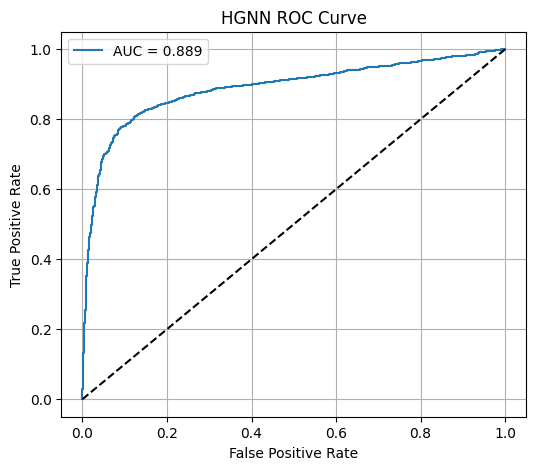

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(
    test_results["fpr"],
    test_results["tpr"],
    label=f"AUC = {test_results['auc']:.3f}"
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("HGNN ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
